# Denoise image using Kornia and Ivy's Transpiler

## Introduction

This tutorial is adapted from [Kornia's official tutorial](https://kornia.github.io/tutorials/nbs/total_variation_denoising.html). We demonstrate how to denoise an image using the differentiable total_variation loss, leveraging Ivy's Transpiler to run these augmentations in TensorFlow using `ivy.transpile`. 

### Original Tutorial Credits
The original tutorial and code are courtesy of [Kornia](https://kornia.github.io/). This notebook serves as an adapted version, showcasing the integration with Ivy's Transpiler for TensorFlow compatibility.



<a href="https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/nbs/total_variation_denoising.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in google colab"></a>



## Installation and Setup

In [1]:
%%capture
!pip install kornia
!pip install kornia-rs
!pip install matplotlib
!pip install -q ivy

!rm -rf ivy_transpiled_outputs/

In [1]:
import kornia as K
import matplotlib.pyplot as plt
import torch
import torchvision
import ivy
import tensorflow as tf 

/opt/miniconda/envs/multienv/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
2024-10-16 06:37:47.910164: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 06:37:48.545476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 06:37:48.763392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered


 This line lazily transpiles everything in the kornia api to `TensorFlow`, and creates a new module for this transpiled version of kornia.
Because the transpilation happens lazily, no function or class will be transpiled until it's actually called.

In [2]:
tf_kornia = ivy.transpile(K, source='torch', target="tensorflow")

In [3]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


url = "https://github.com/kornia/data/raw/main/doraemon.png"
download_image(url)

'doraemon.png'

## Defining `imshow` function

In [4]:
%%writefile imshow.py 

import kornia as K
import matplotlib.pyplot as plt
import torch
import torchvision

def imshow(input: torch.Tensor):
    out = torchvision.utils.make_grid(input, nrow=2, padding=5)
    out_np = K.utils.tensor_to_image(out)
    plt.imshow(out_np)
    plt.axis("off")
    plt.show()

Overwriting imshow.py


## Transpiling `imshow` Function to TensorFlow

In [5]:
from imshow import imshow
transpiled_imshow = ivy.transpile(imshow, source='torch', target='tensorflow')

## loading an visualizing the image. 

This cell triggers the transpilation of `kornia.io.load_image` from PyTorch to TensorFlow. Due to Ivy's lazy transpilation, the actual compilation occurs only when the function is called.

2024-10-16 06:38:06.586462: E tensorflow/core/util/util.cc:131] oneDNN supports DT_UINT8 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


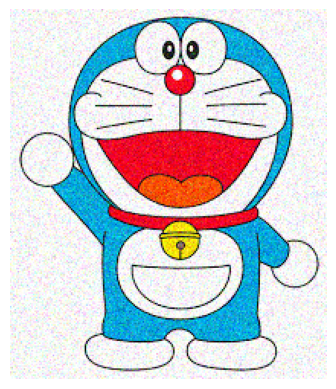

In [6]:
# read the image with kornia and add a random noise to it
img = tf_kornia.io.load_image("doraemon.png", tf_kornia.io.ImageLoadType.RGB32)  # CxHxW

noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.1)
# Add noise to the image and clamp values between 0 and 1
noisy_image_tf = tf.clip_by_value(img + noise, 0.0, 1.0)
transpiled_imshow(noisy_image_tf)

## Defining Total Variation Denoising Network

In [7]:
%%writefile TVDenoise.py

import torch 
import kornia as K 

class TVDenoise(torch.nn.Module):
    def __init__(self, noisy_image):
        super().__init__()
        self.l2_term = torch.nn.MSELoss(reduction="mean")
        self.regularization_term = K.losses.TotalVariation()
        # create the variable which will be optimized to produce the noise free image
        self.clean_image = torch.nn.Parameter(data=noisy_image.clone(), requires_grad=True)

    def forward(self, noisy_image):
        return self.l2_term(self.clean_image, noisy_image) + 0.0001 * self.regularization_term(self.clean_image)

    def get_clean_image(self):
        return self.clean_image

Overwriting TVDenoise.py


## Transpiling `TVDenoise` Network to TensorFlow

In [8]:
from TVDenoise import TVDenoise
transpiledTVDenoise = ivy.transpile(TVDenoise, source="torch", target="tensorflow")


## Running Optimization Loop

In [9]:

tv_denoiser = transpiledTVDenoise(noisy_image_tf)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
num_iters = 500

for i in range(num_iters):
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(tv_denoiser(noisy_image_tf))
    
    # Every 50 iterations, print the loss
    if i % 50 == 0:
        print(f"Loss in iteration {i} of {num_iters}: {loss.numpy():.3f}")
    
    # Compute gradients and apply optimization step
    gradients = tape.gradient(loss, tv_denoiser.trainable_variables)
    optimizer.apply_gradients(zip(gradients, tv_denoiser.trainable_variables))

Loss in iteration 0 of 500: 3.065
Loss in iteration 50 of 500: 2.707
Loss in iteration 100 of 500: 2.342
Loss in iteration 150 of 500: 2.047
Loss in iteration 200 of 500: 1.812
Loss in iteration 250 of 500: 1.629
Loss in iteration 300 of 500: 1.486
Loss in iteration 350 of 500: 1.375
Loss in iteration 400 of 500: 1.290
Loss in iteration 450 of 500: 1.223


## Visualizing Results

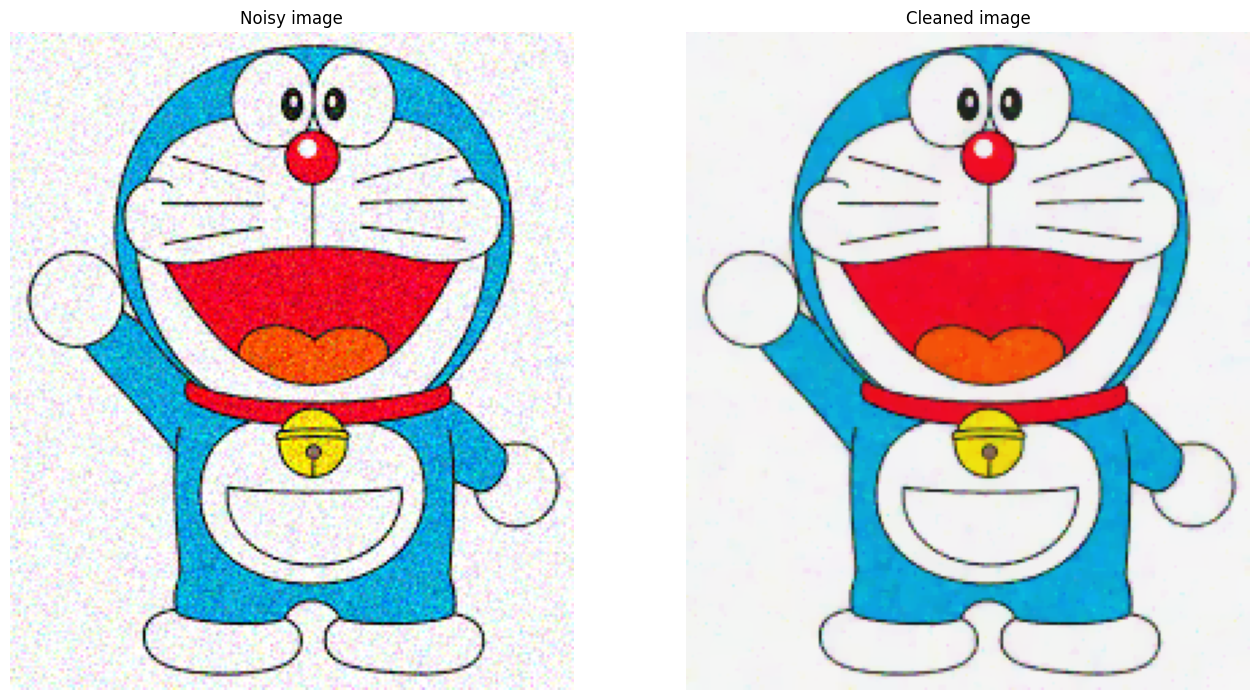

In [10]:
# convert back to numpy
img_clean = tf_kornia.utils.tensor_to_image(tv_denoiser.get_clean_image())

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].axis("off")
axs[0].set_title("Noisy image")
axs[0].imshow(tf_kornia.tensor_to_image(noisy_image_tf))

axs[1].axis("off")
axs[1].set_title("Cleaned image")
axs[1].imshow(img_clean)

plt.show()

## Conclusion
In this tutorial, we demonstrated how to leverage Ivy's Transpiler to run Kornia's total variation denoising algorithm in TensorFlow.

### What's Next?
Want to explore more? Dive into our [documentation](https://www.docs.ivy.dev/) for in-depth guides, tutorials, and API references. Your feedback is invaluable – join our [Discord](https://discord.com/invite/vKqazsCK2Y) to share your thoughts and suggestions.